# sofa

The purpose of this notebook is to try out some initial explorations
of the moving sofa problem.

## Imports

In [9]:
import numpy as np
from PIL import Image, ImageDraw

In [43]:
from IPython.display import display

## Learn how to make and show a simple image

In [10]:
np_arr = np.zeros((200, 200, 3))

In [12]:
im = Image.fromarray(np_arr.astype(np.uint8))

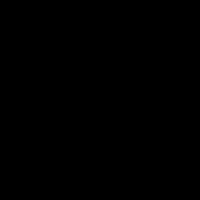

In [14]:
im

In [48]:
# Let's make a 20-pixel-wide hallway corner.

HALLWAY_WIDTH = 20

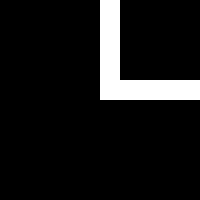

In [50]:
# Let's make a 20-pixel-wide hallway corner.

x_lo = 100
x_hi = lo + HALLWAY_WIDTH

y_lo = 100 - HALLWAY_WIDTH
y_hi = 100

np_arr = np.zeros((200, 200, 3))
np_arr[y_lo:y_hi, x_lo:] = 255
np_arr[:y_hi, x_lo:x_hi] = 255
im = Image.fromarray(np_arr.astype(np.uint8))
im

# Learn how to rotate an image

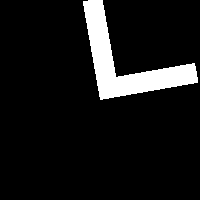

In [51]:
im.rotate(10)

# Learn how to take the intersection of two images

In [52]:
np_arr = np.asarray(im).astype(np.float32) / 255
np.min(np_arr), np.max(np_arr)

(0.0, 1.0)

In [53]:
def to_array(im):
    return np.asarray(im).astype(np.float32) / 255

In [54]:
def to_im(arr):
    return Image.fromarray((arr * 255).astype(np.uint8))

In [55]:
def intersect_images(im1, im2):
    arr1 = to_array(im1)
    arr2 = to_array(im2)
    return to_im(arr1 * arr2)

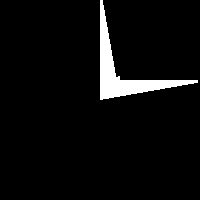

In [56]:
intersect_images(im, im.rotate(10))

## Be able to find the intersection of an arbitrary rotate around an arbitrary point

In [47]:
im.size

(200, 200)

In [ ]:
HALLWAY_WIDTH = 

In [57]:
def find_next_intersection(pos, isect, angle, center):
    ''' This accepts the following parameters:
        * pos    = The hallway in its current position; an Image object.
        * isect  = The intersection of all previous steps; an Image object.
        * angle  = The angle, in degrees (with apologies), of the rotation.
        * center = The center of rotation. (0, 0) is the original outside corner.
                   (1, 1) is the original inside corner.
    '''
    
    # Convert the center to image-based coordinates.
    w, h = im.size
    center = (
        w // 2 - center[1] * HALLWAY_WIDTH,
        h // 2 + center[0] * HALLWAY_WIDTH
    )
    
    # XXX This whole function while I write it.
    
    print()
    print('pos:')
    display(pos)
    
    print()
    print('isect:')
    display(isect)
    
    num_steps = 3
    
    for i in range(num_steps):
        pos = pos.rotate(angle / num_steps, center=center)
        print('\npos:'); display(pos)
        isect = intersect_images(isect, pos)
        print('\nisect:'); display(isect)
    
    


pos:


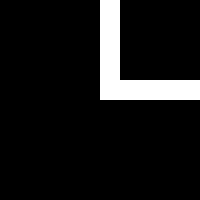


isect:


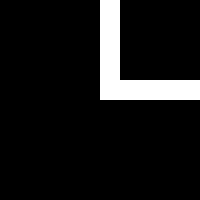


pos:


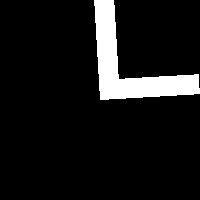


isect:


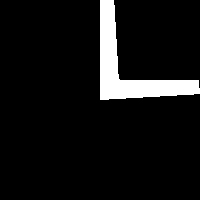


pos:


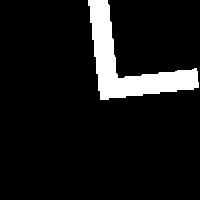


isect:


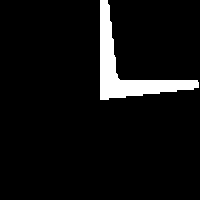


pos:


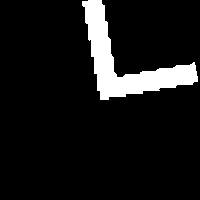


isect:


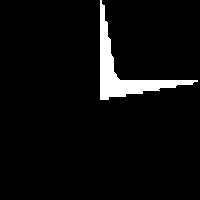

In [58]:
find_next_intersection(im, im, 10, (0, 0))